# Import required libraries

In [1]:
%matplotlib inline

import datacube
from datacube.testutils import io
import sys
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

sys.path.append("../Scripts")
from deafrica_bandindices import calculate_indices

# Import Level 1 data - from file
tiffs in same folder as this ipynb.

B3 is Band 3 - Landsat 8 green band

B6 is Band 6 - Landsat 8 SWIR 1 band

In [2]:
l1_green = io.rio_slurp_xarray('LC08_L1TP_204052_20180109_20180119_01_T1_B3.tiff')
l1_swir1 =  io.rio_slurp_xarray('LC08_L1TP_204052_20180109_20180119_01_T1_B6.tiff')

Combine into an xarray dataset

In [3]:
ds_l1 = l1_green.to_dataset(name = 'green')
ds_l1['swir1'] = l1_swir1
ds_l1

<xarray.Dataset>
Dimensions:      (x: 7601, y: 7761)
Coordinates:
  * y            (y) float64 1.395e+06 1.395e+06 ... 1.162e+06 1.162e+06
  * x            (x) float64 3.039e+05 3.039e+05 ... 5.319e+05 5.319e+05
    spatial_ref  int32 32628
Data variables:
    green        (y, x) uint16 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    swir1        (y, x) uint16 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0

# Import Level 2 data - from datacube

Load green and swir1 bands only.

In [4]:
dc = datacube.Datacube(app='s2')

# Show all datacube products
#dc.list_products()

query = {}
query['product'] = 'ls8_usgs_sr_scene'
query['id'] = '13b9c5f0-65f0-5d2e-8473-5bbfc92a9673'
query['measurements'] = ['green','swir1']

In [5]:
ds_l2 = dc.find_datasets(**query)
query['output_crs'] = ds_l2[0].metadata_doc['grid_spatial']['projection']['spatial_reference']
query['resolution'] = (-30,30)
query['align'] = (15,15)

In [6]:
l2_data = dc.load(**query)
l2_data

<xarray.Dataset>
Dimensions:      (time: 1, x: 7601, y: 7761)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-09T11:22:11.054208
  * y            (y) float64 1.395e+06 1.395e+06 ... 1.162e+06 1.162e+06
  * x            (x) float64 3.039e+05 3.039e+05 ... 5.319e+05 5.319e+05
    spatial_ref  int32 32628
Data variables:
    green        (time, y, x) int16 -9999 -9999 -9999 ... -9999 -9999 -9999
    swir1        (time, y, x) int16 -9999 -9999 -9999 ... -9999 -9999 -9999
Attributes:
    crs:           epsg:32628
    grid_mapping:  spatial_ref

In [7]:
np.testing.assert_allclose(ds_l1['x'].values, l2_data.x.values)

# Calculate Level 2 MNDWI

In [8]:
# This def is from Caitlin's notebook, note NVDI and NDWI have been removed here
# Note typo in original def - MNDWI incorrectly uses NIR in the denominator

def calculate_band_indices(dc):
    dc['mndwi'] = (dc.green - dc.swir1)/(dc.green + dc.swir1)
    return(dc)

dc_level2 = calculate_band_indices(l2_data)

## ... and plot

In [9]:
#dc_level2['mndwi'].plot(figsize=(10,10))

# Calculate Level 1 MNDWI

In [10]:
ds_l1 = calculate_indices(ds_l1, index = 'MNDWI', collection = 'c1') # use drop = True to get rid of bands

In [11]:
ds_l1

<xarray.Dataset>
Dimensions:      (x: 7601, y: 7761)
Coordinates:
  * y            (y) float64 1.395e+06 1.395e+06 ... 1.162e+06 1.162e+06
  * x            (x) float64 3.039e+05 3.039e+05 ... 5.319e+05 5.319e+05
    spatial_ref  int32 32628
Data variables:
    green        (y, x) uint16 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    swir1        (y, x) uint16 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    MNDWI        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [12]:
#ds_l1.MNDWI.plot(figsize=(10,10))

In [13]:
# fig, axes = plt.subplots(ncols=2)

# ds_l1.MNDWI.plot(ax = axes[0])
# dc_level2['mndwi'].plot(ax = axes[1])

# plt.draw()

In [14]:
# fig3 = plt.figure(figsize=(18,6))
# fig3.suptitle("Comparison of MNDWI between Level-1 (LHS) and Level-2 (RHS)")

# plt.subplot(1, 2, 1)
# ds_l1.MNDWI.plot(cmap='RdBu', vmin=-1, vmax=1)

# plt.subplot(1, 2, 2)
# dc_level2.mndwi.plot(cmap='RdBu', vmin=-1, vmax=1)

# plt.show()

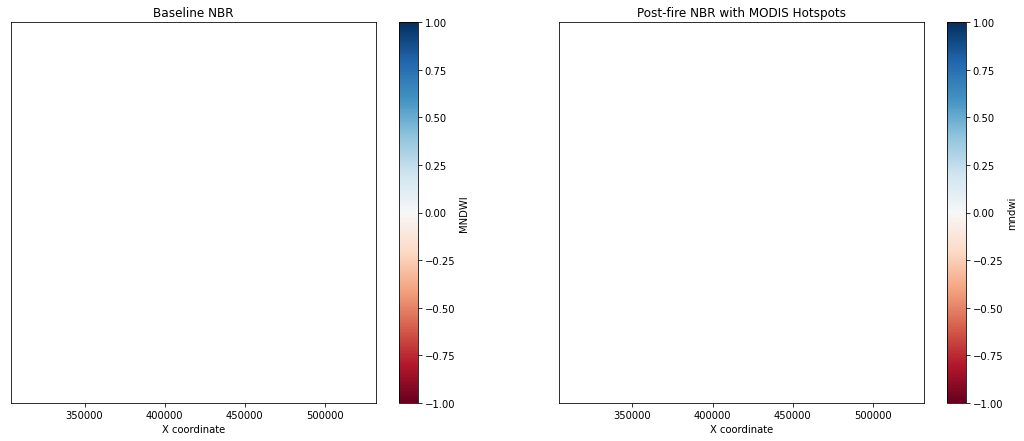

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

# Visualise baseline image as NBR image
ds_l1.MNDWI.plot(cmap='RdBu', vmin=-1, vmax=1, ax=ax1)
ax1.set_title('Baseline NBR')
ax1.yaxis.set_visible(False)
ax1.set_xlabel('X coordinate')

# Visualise post-fire image as NBR image and overplot hotspots
dc_level2.mndwi.plot(cmap='RdBu', vmin=-1, vmax=1, ax=ax2)
ax2.set_title('Post-fire NBR with MODIS Hotspots')
ax2.yaxis.set_visible(False)
ax2.set_xlabel('X coordinate');